In [15]:
import numpy as np 
import pandas as pd
import pickle, glob
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

def to_datetime(date):

    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

In [213]:
year = 2023
place = 'Keelung'

stages= 4 if year == 2023 else 3
path = glob.glob(f'../Results/soundsepration/{place}-5min/202?*_{year}_{stages}stage_separation/')[0]
df = pd.read_pickle(glob.glob(f"{path}/{place}_{year}_diurnal_variations_nostd_{year}??_S0.pkl")[0])  

days, hr = df['level'].shape

dtime = pd.read_csv(f"{path}/{place}_{year}_index_variations.csv")
dtime = pd.to_datetime(dtime['Time'][~dtime['H'].isna()])
t1 = dtime.values[0]; t2 = dtime.values[-1]

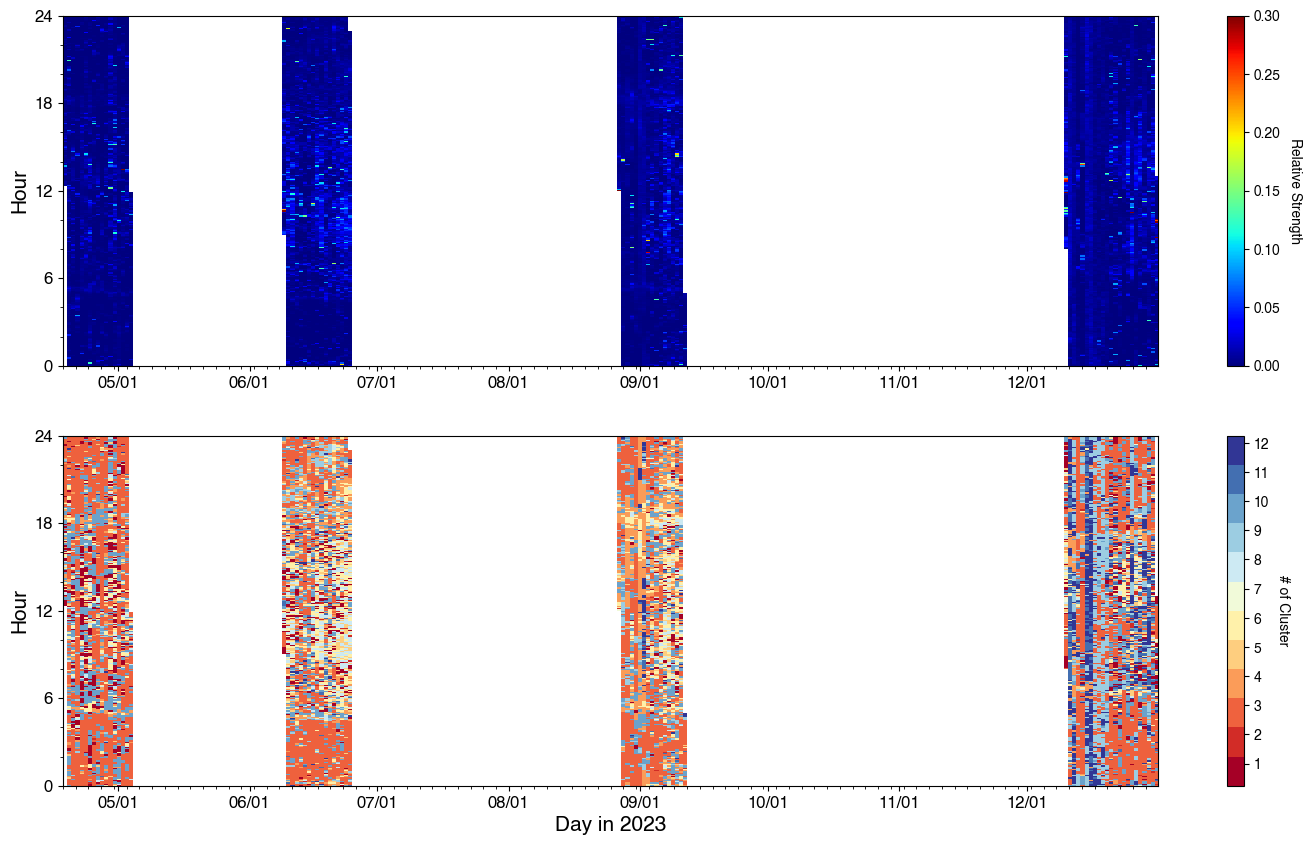

In [214]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(2, 1, figsize=(days/15, 10))
hr_boundary = [0, 24]
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates

    
im1 = ax[0].imshow(df['level'].T, vmin=(np.nanmin(df['level'])), vmax=0.3, #(np.nanmax(df['level'])), 
            origin='lower', aspect='auto', cmap=cm.jet, interpolation='none',
            extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])
            
# im2 = ax.imshow(plot_tide_max.T, vmin=0, vmax=1, 
#             origin='lower', aspect='auto', cmap=cm.Reds, interpolation='none',
#             extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])
# im3 = ax.imshow(plot_tide_min.T, vmin=0, vmax=1, 
#             origin='lower', aspect='auto', cmap=cm.Reds_r, interpolation='none',
#             extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])

ax[0].xaxis_date()
ax[0].set_ylabel('Hour', fontsize=15)
ax[0].yaxis.set_minor_locator(MultipleLocator(2))
ax[0].yaxis.set_major_locator(MultipleLocator(6))
ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[0].tick_params(axis='both', which='major', labelsize=12)
cbar1 = plt.colorbar(im1)  
cbar1.ax.get_yaxis().labelpad = 15
cbar1.set_label('Relative Strength', rotation=270)


n_clusters=int(np.nanmax(df['cluster']))

#-------- specific colorbar 
# cptpath = '/Users/tong/opt/get-cpt'
# import os, sys
# sys.path.append(cptpath)
# import get_cpt
# cmap_url = 'http://soliton.vm.bytemark.co.uk/pub/cpt-city/gmt/GMT_panoply.cpt'
# cmap = get_cpt.get_cmap(cmap_url, method='list', N=n_clusters)
cmap = cm.get_cmap('RdYlBu', n_clusters)
im2 = ax[1].imshow(df['cluster'].T, vmin=int(np.nanmin(df['cluster'])), vmax=int(np.nanmax(df['cluster'])), 
                origin='lower', aspect='auto', cmap=cmap, interpolation='none',
                extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])
# ax[1].xaxis_date()
ax[1].set_ylabel('Hour', fontsize=15)
ax[1].set_xlabel(f'Day in {year}', fontsize=15)
ax[1].yaxis.set_minor_locator(MultipleLocator(2))
ax[1].yaxis.set_major_locator(MultipleLocator(6))
ax[1].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar2 = plt.colorbar(im2)  
cbar2.ax.get_yaxis().labelpad = 15
cbar2.set_label('# of Cluster', rotation=270)
if n_clusters == 2:
    tick_locs = (np.arange(1, n_clusters+1) )*(n_clusters-1)/n_clusters
else:
    tick_locs = (np.arange(1, n_clusters+1) + 0.85)*(n_clusters-1)/n_clusters
cbar2.set_ticks(tick_locs)
cbar2.set_ticklabels(np.arange(1, n_clusters+1))


# fig.savefig(f'{path}/{place}_{year}_noise_diurnal_variations_wTidal.png', dpi=200)
# fig.savefig(f'{path}/{place}_{year}_noise_diurnal_variations_wTidal.pdf', dpi=200)

In [215]:
df['level'].shape

(265, 288)

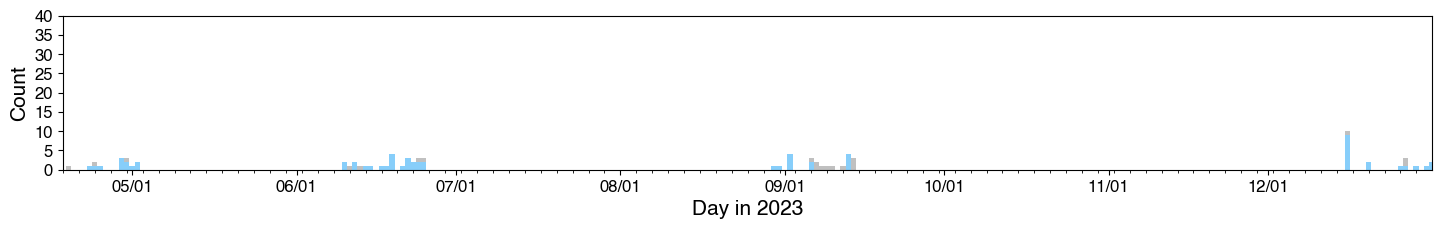

In [216]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(1, 1, figsize=(days/15, 2))

x_time = []; y_count_in_day = []; y_count_day=[]; y_count_night=[]
for ii in range(df['level'].shape[0]):
    begintime = to_datetime(t1)+timedelta(days=ii)
    df_ = df['level'][ii,:]
    count_in_day = np.sum(df_>= 0.1)
    
    df_day = df['level'][ii, 60:216]
    count_day = np.sum(df_day>= 0.1)
    
    df_night = df['level'][ii, 0:60]
    df_night_ = df['level'][ii, 216:288]
    count_night = np.sum(df_night>= 0.1)+np.sum(df_night_>= 0.1)
    
    x_time.append(begintime)
    y_count_in_day.append(count_in_day)
    y_count_day.append(count_day)
    y_count_night.append(count_night)
    
# plt.bar(x_time,y_count_in_day)
count={'day':y_count_day, 'night':y_count_night}
bottom = np.zeros(days)
colors = ['lightskyblue', 'silver']
for i, (label, noise_count) in enumerate(count.items()):
    p = plt.bar(x_time, noise_count, width=1, bottom=bottom, linewidth= 0.5, color=colors[i])
    bottom += noise_count

plt.xlim(to_datetime(t1), to_datetime(t2))
if year == 2023 and place=='Taoyuan':
    ax.yaxis.set_major_locator(MultipleLocator(25))
    plt.hlines(y=25, xmin=to_datetime(t1), xmax=to_datetime(t2), color='lightgrey', lw=1, ls='--')
else:
    ax.yaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'Day in {year}', fontsize=15)
ax.set_ylabel(f'Count', fontsize=15)
if place == 'Taoyuan':
    ax.set_ylim(0,25)
else:
    ax.set_ylim(0,40)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))


plt.savefig(f'{path}/{place}_{year}_count_noise.png', dpi=200)
plt.savefig(f'{path}/{place}_{year}_count_noise.pdf', dpi=200)